In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

from matplotlib.projections import PolarAxes
from mpl_toolkits.axisartist import floating_axes
from mpl_toolkits.axisartist import grid_finder

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

import sys
sys.path.append('../../../src/')
from mask import polygon_to_mask
from namelist import *

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

In [3]:
simvar = 'O3'
obsvar = 'O3'

In [4]:
df = pd.DataFrame(
    index=pd.date_range(start='2023-09-01T00', end='2023-09-30T23', freq='H')
)

## 获取模拟与观测数据

In [33]:
years = [2014,2015,2016,2019,2021,2022]

for year in years:
    ds = xr.open_dataset(datadir + f'processed/Sep_{year}/Sep_{year}_chem.nc')
    data_sim = ds[simvar][:,0,:,:]

    shp = gpd.read_file(shp_PRD_adm)
    lon = data_sim.longitude
    lat = data_sim.latitude
    mask    = polygon_to_mask(shp.geometry[0], lon, lat)
    mask_da = xr.DataArray(mask, dims=('y','x'))
    masked_sim  = data_sim.where(mask_da)
    sim    = masked_sim.mean(dim=('x','y'),skipna=True)

    dfobs = pd.read_excel(obsSep + f'site_{obsvar}_{year}.xlsx',index_col=0)
    obs = dfobs.mean(axis=1,skipna=True)
    obs.interpolate(method='linear',inplace=True)
    
    df[f'sim_{year}']=sim
    df[f'obs_{year}']=obs.values
    print(f'Complete {year}')

Complete 2014
Complete 2015
Complete 2016
Complete 2019
Complete 2021
Complete 2022


In [34]:
df

,sim_2014,obs_2014,sim_2015,obs_2015,sim_2016,obs_2016,sim_2019,obs_2019,sim_2021,obs_2021,sim_2022,obs_2022
2023-09-01 00:00:00,19.893482,11.000000,61.206947,16.387755,57.678703,48.796296,49.845322,17.188679,55.047680,25.734177,97.564598,35.605263
2023-09-01 01:00:00,19.462290,11.938776,52.959999,14.509804,50.192116,45.148148,54.671875,17.653934,48.916603,22.278481,100.690735,31.636364
2023-09-01 02:00:00,18.984476,14.469388,45.014439,16.780000,50.527233,42.370370,55.858677,18.119188,44.523220,18.607595,104.467567,33.276316
2023-09-01 03:00:00,18.580616,13.540000,36.795097,15.846154,53.278728,40.800000,56.403931,18.584442,40.221786,16.909091,104.900711,32.822785
2023-09-01 04:00:00,18.187109,15.576923,30.426170,18.760000,53.077427,39.145455,56.501808,19.049697,36.084728,14.320513,105.612991,30.037975
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30 19:00:00,89.116005,111.846154,169.976883,105.472727,127.171875,24.265306,116.306900,161.409392,126.017708,129.680000,49.679966,24.610390
2023-09-30 20:00:00,86.708298,97.055556,152.762009,89.272727,112.650917,19.520000,106.932388,130.925926,115.252640,113.280000,43.480785,22.935065
2023-09-30 21:00:00,91.322334,82.811321,138.593338,81.709091,98.792290,15.540000,102.569580,106.581818,102.656975,97.589744,40.186298,21.851351
2023-09-30 22:00:00,94.769409,69.886792,127.428726,75.345455,86.366257,15.836735,95.447533,91.363636,92.894745,85.012658,36.606552,19.150685


## 定义绘图函数

In [23]:
def set_tayloraxes(fig, location):
    trans = PolarAxes.PolarTransform()
    r1_locs = np.hstack((np.arange(1,10)/10.0,[0.95,0.99]))
    t1_locs = np.arccos(r1_locs)        
    gl1 = grid_finder.FixedLocator(t1_locs)    
    tf1 = grid_finder.DictFormatter(dict(zip(t1_locs, map(str,r1_locs))))
    r2_locs = np.arange(0,2.5,0.25)
    r2_labels = ['0 ', '0.25 ', '0.50 ', '0.75 ', 'REF ', '1.25 ', '1.50 ', '1.75 ','2.0','2.25']
    gl2 = grid_finder.FixedLocator(r2_locs)
    tf2 = grid_finder.DictFormatter(dict(zip(r2_locs, map(str,r2_labels))))
    ghelper = floating_axes.GridHelperCurveLinear(trans,extremes=(0,np.pi/2,0,2.25),
                                                  grid_locator1=gl1,tick_formatter1=tf1,
                                                  grid_locator2=gl2,tick_formatter2=tf2)
    ax = floating_axes.FloatingSubplot(fig, location, grid_helper=ghelper)
    fig.add_subplot(ax)

    ax.axis["top"].set_axis_direction("bottom")  
    ax.axis["top"].toggle(ticklabels=True, label=True)
    ax.axis["top"].major_ticklabels.set_axis_direction("top")
    ax.axis["top"].label.set_axis_direction("top")
    ax.axis["top"].label.set_text("Correlation")
    ax.axis["top"].label.set_fontsize(14)
    ax.axis["left"].set_axis_direction("bottom") 
    ax.axis["left"].label.set_text("Standard deviation(Normalized)")
    ax.axis["left"].label.set_fontsize(14)
    ax.axis["right"].set_axis_direction("top")   
    ax.axis["right"].toggle(ticklabels=True)
    ax.axis["right"].major_ticklabels.set_axis_direction("left")
    ax.axis["bottom"].set_visible(False)         
    ax.grid(True)
    polar_ax = ax.get_aux_axes(trans)   

    rs,ts = np.meshgrid(np.linspace(0,2.25,100),
                            np.linspace(0,np.pi/2,100))
    rms = np.sqrt(1 + rs**2 - 2*rs*np.cos(ts))
    CS = polar_ax.contour(ts, rs,rms,colors='gray',linestyles='--')
    plt.clabel(CS, inline=1, fontsize=10)
    t = np.linspace(0,np.pi/2)
    r = np.zeros_like(t) + 1
    polar_ax.plot(t,r,'r--')
    polar_ax.text(np.pi/2+0.045,1.02, " 1.00", size=10.3,ha="right", va="top",
                  bbox=dict(boxstyle="square",ec='w',fc='w'))

    return polar_ax

def plot_taylor(axes, refsample, sample, *args, **kwargs):
    std = np.std(refsample)/np.std(sample)
    corr = np.corrcoef(refsample, sample) 
    theta = np.arccos(corr[0,1])
    t,r = theta,std
    d = axes.plot(t,r, *args, **kwargs) 
    return d


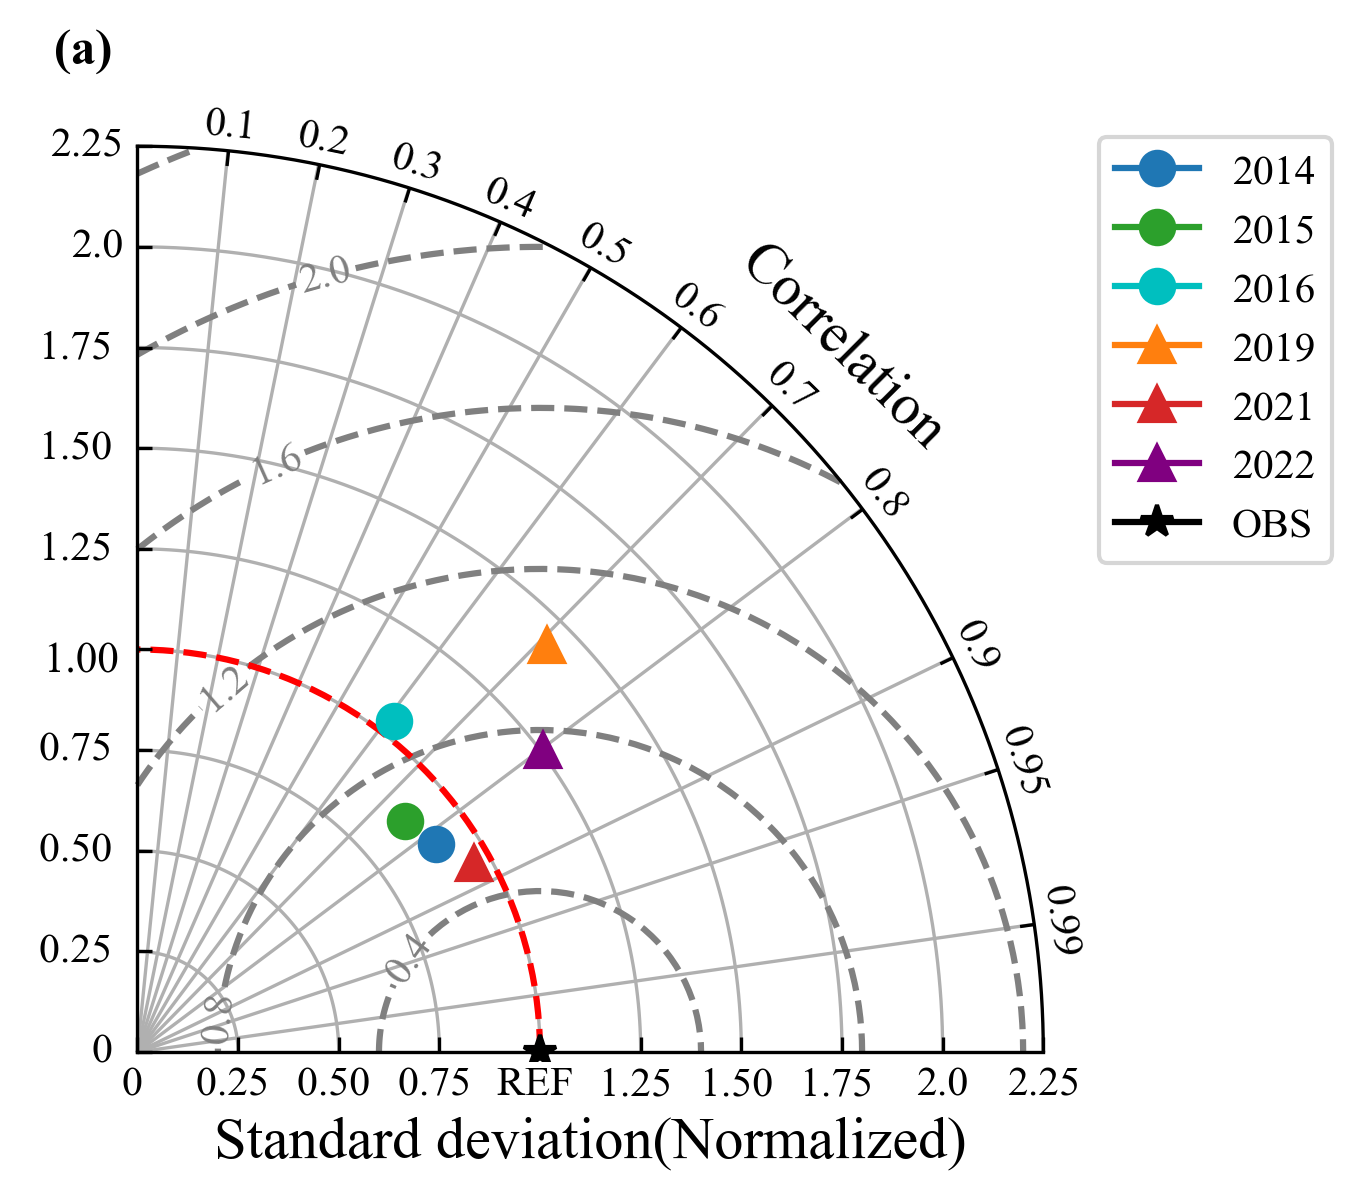

In [66]:
markersyle_low = {
    'marker':'o',
    'markersize':8,
}
markersyle_high = {
    'marker':'^',
    'markersize':8,
}

fig = plt.figure(figsize=(4,4),dpi=300)
ax = set_tayloraxes(fig, 111)

d1 = plot_taylor(ax,df['obs_2014'],df['sim_2014'],label='2014',color='tab:blue', **markersyle_low)
d2 = plot_taylor(ax,df['obs_2015'],df['sim_2015'],label='2015',color='tab:green', **markersyle_low)
d3 = plot_taylor(ax,df['obs_2016'],df['sim_2016'],label='2016',color='c', **markersyle_low)

d4 = plot_taylor(ax,df['obs_2019'],df['sim_2019'],label='2019',color='tab:orange', **markersyle_high)
d5 = plot_taylor(ax,df['obs_2021'],df['sim_2021'],label='2021',color='tab:red', **markersyle_high)
d6 = plot_taylor(ax,df['obs_2022'],df['sim_2022'],label='2022',color='purple', **markersyle_high)

d7 = plot_taylor(ax,df['obs_2014'],df['obs_2014'],label='OBS',color='k',marker='*',markersize=8)

ax.text(-0.08, 1.08, '(a)', transform=ax.transAxes, fontsize=12, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)